In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
model.q

tensor([2.1493e-01, 4.0864e-01, 1.3857e-12])

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import torch
import gpytorch
from gpytorch import kernels, likelihoods
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xarray as xr
import tqdm
import utils as utils

base_dir = os.path.join(os.getcwd(), '..')
sys.path.append(base_dir)

from src.fair import run, get_params
from src.preprocessing.glob import load_emissions_dataset, load_response_dataset
from src.models import ThermalBoxesGP
from src.structures import Scenario, ScenarioDataset

<IPython.core.display.Javascript object>

In [3]:
input_abrupt4x = load_emissions_dataset('../data/inputs_abrupt-4xCO2.nc')
output_abrupt4x = load_response_dataset('../data/outputs_abrupt-4xCO2.nc')
# Fill in missing output values with nans
output_abrupt4x = output_abrupt4x.reindex(dict(time=list(range(1, 501))), fill_value=np.nan)

In [6]:
weights = np.cos(np.deg2rad(output_abrupt4x.lat))
global_CO2 = input_abrupt4x.CO2
global_tas = output_abrupt4x.tas.weighted(weights).mean(['lat', 'lon', 'member'])

In [8]:
xr_input = input_abrupt4x
xr_output = output_abrupt4x

# Extract time steps array
time = xr_input.time.values

# Extract cumulative emissions
cum_CO2_emissions = xr_input.CO2.values
cum_emissions = cum_CO2_emissions

# Compute emissions
CO2_emissions = np.append(cum_CO2_emissions[0], np.diff(cum_CO2_emissions))
CH4_emissions = np.zeros_like(CO2_emissions)
SO2_emissions = np.zeros_like(CO2_emissions)
BC_emissions = np.zeros_like(CO2_emissions)
emissions = np.stack([CO2_emissions, CH4_emissions, SO2_emissions, BC_emissions])

# Compute average temperature anomaly
weights = np.cos(np.deg2rad(xr_output.lat))
tas = xr_output.tas.weighted(weights).mean(['lat', 'lon', 'member']).data

# Create scenario
abrupt4x = Scenario(name='abrupt-4xCO2',
                    timesteps=torch.from_numpy(time).float(),
                    emissions=torch.from_numpy(emissions).float().T,
                    tas=torch.from_numpy(tas).float())

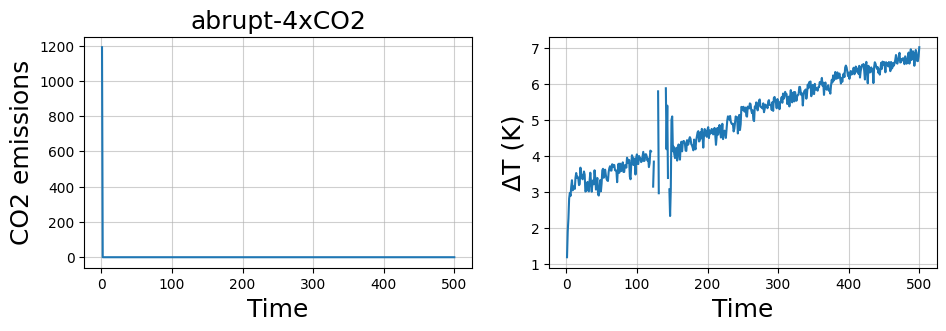

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(11, 3))
fontsize = 18
ax[0].plot(abrupt4x.timesteps, abrupt4x.emissions[:, 0])
ax[0].grid(alpha=0.6)
ax[0].set_xlabel("Time", fontsize=fontsize)
ax[0].set_ylabel("CO2 emissions", fontsize=fontsize)
ax[0].set_title("abrupt-4xCO2", fontsize=fontsize)

ax[1].plot(abrupt4x.timesteps, abrupt4x.tas)
ax[1].grid(alpha=0.6)
ax[1].set_xlabel("Time", fontsize=fontsize)
ax[1].set_ylabel("ΔT (K)", fontsize=fontsize)
plt.show()

In [13]:
base_kwargs = utils.get_fair_params()
d = base_kwargs['d']
q = base_kwargs['q']

forcing_kernel = kernels.MaternKernel(nu=1.5, ard_num_dims=4, active_dims=[1, 2, 3, 4])
forcing_kernel = kernels.ScaleKernel(forcing_kernel)

kernel = forcing_kernel

In [14]:
train_keys = ['historical']
inputs = {key: load_emissions_dataset(f'../data/inputs_{key}.nc') for key in train_keys}
outputs = {key: load_response_dataset(f'../data/outputs_{key}.nc') for key in train_keys}

def make_scenario(name, hist_scenario=None):
    time, _, emission, tas = utils.extract_arrays(inputs[name], outputs[name])
    scenario = Scenario(name=name,
                        timesteps=torch.from_numpy(time).float(),
                        emissions=torch.from_numpy(emission).float().T,
                        tas=torch.from_numpy(tas).float(),
                        hist_scenario=hist_scenario)
    return scenario

hist_scenario = make_scenario('historical')
# ssps = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
ssps = []
scenarios = {'historical': hist_scenario}
for name in ssps:
    scenario = make_scenario(name, hist_scenario)
    scenarios[name] = scenario
    
train_scenarios = ScenarioDataset(scenarios=list([scenarios[key] for key in train_keys]),
                                  hist_scenario=hist_scenario)
test_scenarios = ScenarioDataset(scenarios=[abrupt4x],
                                 hist_scenario=None)

In [22]:
likelihood = likelihoods.GaussianLikelihood()
model = ThermalBoxesGP(scenario_dataset=train_scenarios,
                       kernel=kernel,
                       likelihood=likelihood,
                       q=q, d=d,
                       internal_variability=True)

In [23]:
model.kernel.outputscale = 0.546323
model.kernel.base_kernel.lengthscale = torch.tensor([0.986062, 3.141069, 0.030032, 0.02148])
likelihood.noise = 0.005084
model.OU_kernel.outputscale = 0.025922

In [24]:
model = model.eval()

with torch.no_grad():
    test_posterior = model(test_scenarios)
    noisy_pred = likelihood(test_posterior)

/home/bouabid/.pyenv/versions/sandbox/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:25: UserWarning: gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense
  warnings.warn("gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense")


In [25]:
test_times = test_scenarios.timesteps
test_tas = test_scenarios.tas

test_tas_fair = model._compute_mean(test_scenarios)

with torch.no_grad():
    test_prior = model.forward(test_scenarios)
    noisy_test_prior = likelihood(test_prior)

prior_mean = noisy_test_prior.mean + test_tas_fair
prior_lb, prior_ub = noisy_test_prior.confidence_region()
prior_lb = prior_lb.detach() + test_tas_fair
prior_ub = prior_ub.detach() + test_tas_fair

posterior_mean = noisy_pred.mean + test_tas_fair
posterior_lb, posterior_ub = noisy_pred.confidence_region()
posterior_lb = posterior_lb.detach() + test_tas_fair
posterior_ub = posterior_ub.detach() + test_tas_fair

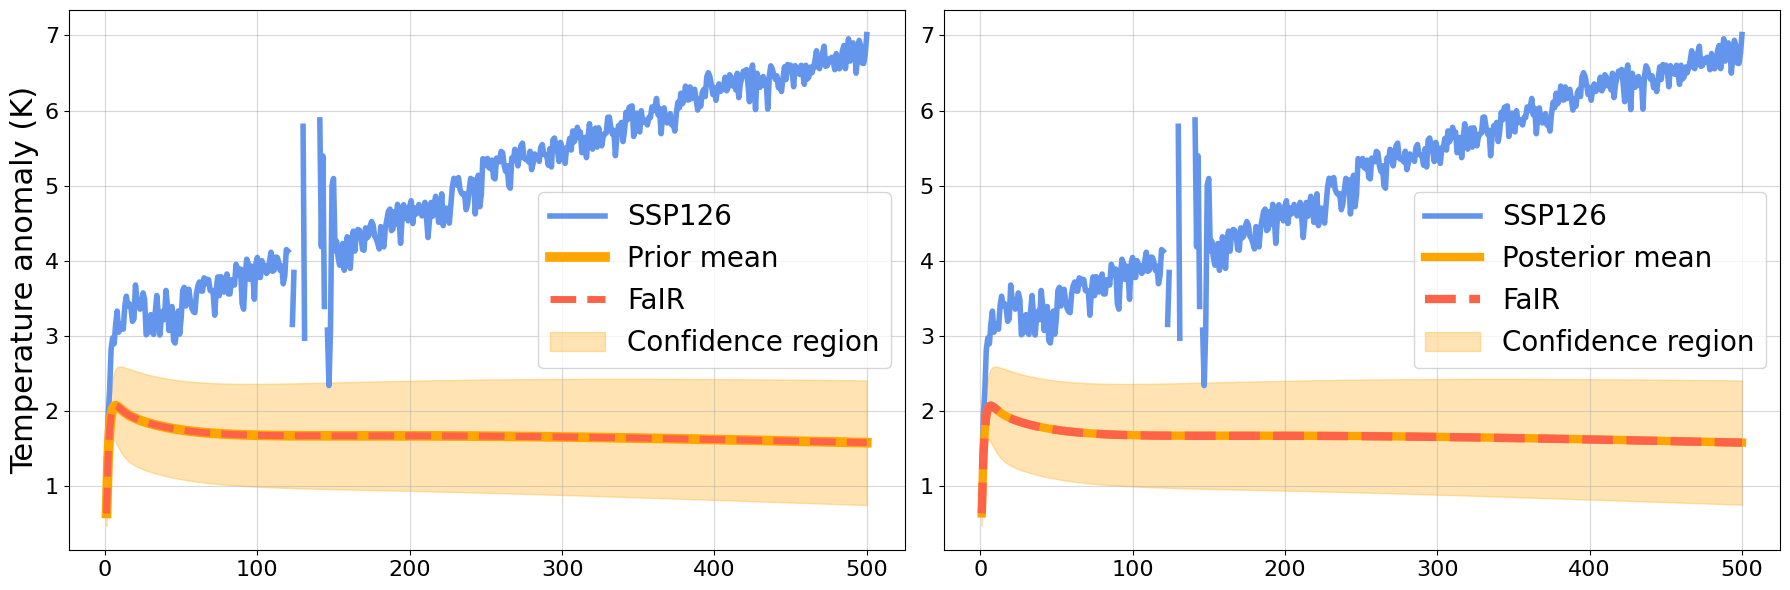

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

ax[0].plot(test_times, test_tas, lw=4, color='cornflowerblue', label='SSP126')
ax[0].set_ylabel('Temperature anomaly (K)', fontsize=22)
ax[0].plot(test_times, prior_mean, color='orange', lw=7, label='Prior mean')
ax[0].plot(test_times, test_tas_fair, color='tomato', ls='--', lw=5, label='FaIR')
ax[0].fill_between(test_times, prior_lb, prior_ub, alpha=0.3, color='orange', label='Confidence region')
ax[0].tick_params(labelsize=16)
ax[0].grid(alpha=0.5)
ax[0].legend(fontsize=20)

ax[1].plot(test_times, test_tas, lw=4, color='cornflowerblue', label='SSP126')
# ax[1].set_ylabel('Temperature anomaly (K)', fontsize=20)
ax[1].plot(test_times, posterior_mean, color='orange', lw=6, label='Posterior mean')
ax[1].plot(test_times, test_tas_fair, color='tomato', ls='--', lw=6, label='FaIR')
ax[1].fill_between(test_times, posterior_lb, posterior_ub, alpha=0.3, color='orange', label='Confidence region')
ax[1].tick_params(labelsize=16)
ax[1].grid(alpha=0.5)
ax[1].legend(fontsize=20)

plt.tight_layout()
plt.show()